In [2]:
%reload_ext autoreload
%autoreload 2
import bmxobs
from bmxobs.SingleFreqGeometry import SingleFreqGeometry
from bmxobs.TheoryPredictor import TheoryPredictor
import fitsio
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import j1
from scipy.optimize import least_squares
import copy

In [3]:
bmxobs.__path__

['/direct/astro+u/wcook/bmxobs/bmxobs']

In [63]:
BMX = bmxobs.BMXObs("pas/210904_2300", channels='all')

D=bmxobs.BMXSingleFreqObs("pas/210904_2300", freq_bins=(1760,1780))
print(D.freq)

MemoryError: Unable to allocate 805. MiB for an array with shape (102997, 2048) and data type float32

In [58]:
print(BMX.freq[0][290])

1178.01516084373


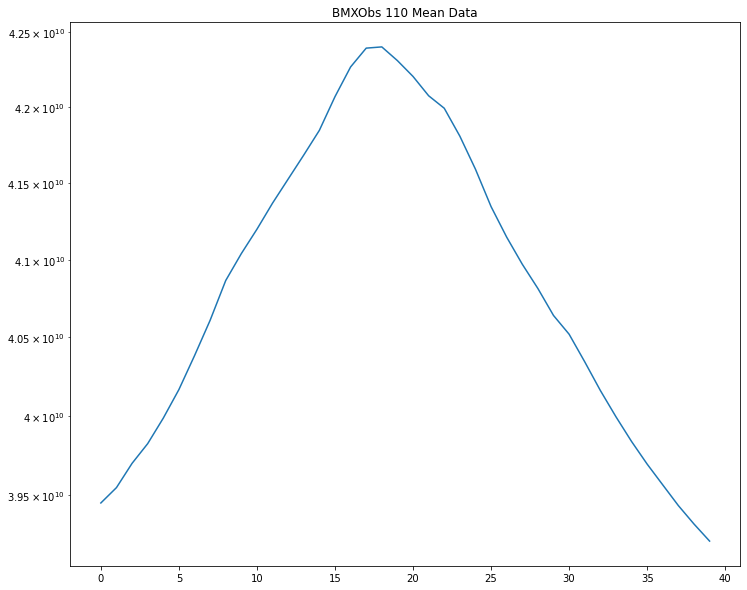

In [64]:
plt.figure(figsize=(12,10))
plt.yscale('log')
plt.plot(BMX[110].mean(axis=0)[1750:1790])
#plt.xlim(1750,1790)
plt.title('BMXObs 110 Mean Data')
plt.show()

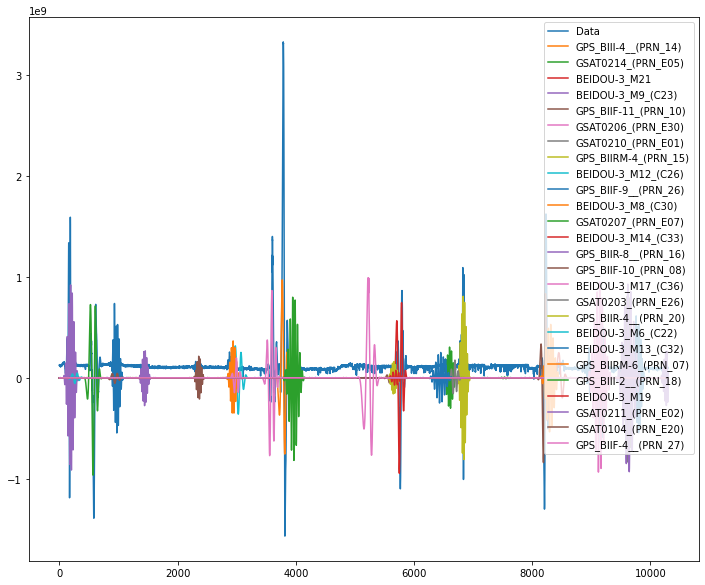

[3787]


In [9]:
cut = [0,len(D[11])]
channel = 23

plt.figure(figsize=(12,10))
plt.plot(D[channel][cut[0]:cut[1]].real,label='Data')

tracks = {}
sats = {}
for n,s in zip(D.sat_id,D.sat):
    if "COS" not in n:
        #dx= np.exp(-np.cos(s['alt'])**2/(2*0.05**2))
        track = np.array([np.cos(s['alt'])*np.cos(s['az']),np.cos(s['alt'])*np.sin(s['az'])]).T
        dx = SingleFreqGeometry(freq=D.freq).point_source(channel,1,track).real
        if max(dx[cut[0]:cut[1]])>0.02:
            plt.plot(dx[cut[0]:cut[1]]*1e9,label=n)
            tracks[n] = track
            sats[n] = dx
        
plt.legend()
plt.show()
print(np.arange(cut[0],cut[1])[D[channel][cut[0]:cut[1]].real==max(D[channel][cut[0]:cut[1]].real)])

In [5]:
def getPhaseFit(Theory):
    detectors = [2,3,4,6,7,8]
    channelSet = [[12],[13,23],[14,24,34],
                  [56],[57,67],[58,68,78]]

    params = []
        
    for i,d in enumerate(detectors):
        ch = channelSet[i]
        names = ['D{}_pos_x'.format(d),
                 'D{}_pos_y'.format(d),
                 'D{}_phi'.format(d)
                ]

        params.append(Theory.fit(names, mode = 'phase', channels = ch, plot=False))
    
    return np.array(params)

In [6]:
def getBeamFit(Theory):
    detectors = [1,2,3,4,5,6,7,8]
    channelSet = [[11],[12,22],[13,23,33],[14,24,34,44],
                  [55],[56,66],[57,67,77],[58,68,78,88]]
    params = []

    for i,d in enumerate(detectors):
        ch = channelSet[i]
        names = ['D{}_beam_center_x'.format(d),
                'D{}_beam_center_y'.format(d),
                'D{}_beam_sigma_x'.format(d),
                'D{}_beam_sigma_y'.format(d),
                'D{}_beam_smooth_x'.format(d),
                'D{}_beam_smooth_y'.format(d)
                ]


        params.append(Theory.fit(names, mode = 'amp', channels = ch, plot=False))
    
    return np.array(params)

In [7]:
def getAmpFit(Theory):
    detectors = [1,2,3,4,5,6,7,8]
    channelSet = [[11],[12,22],[13,23,33],[14,24,34,44],
                  [55],[56,66],[57,67,77],[58,68,78,88]]
    
    for i,d in enumerate(detectors):
        ch = channelSet[i]
        names = ["A{}_{}".format(d,n) for n in Theory.satNames]
        if len(names)>0:
            Theory.fit(names, mode = 'amp', channels = ch, plot=False, output=False)
            
    return

In [8]:
def getAstroFit(Theory):
    detectors = [1,2,3,4,5,6,7,8]
    channelSet = [[11],[12,22],[13,23,33],[14,24,34,44],
                  [55],[56,66],[57,67,77],[58,68,78,88]]
    
    for i,d in enumerate(detectors):
        ch = channelSet[i]
        names = ["A{}_{}".format(d,n) for n in Theory.astroNames]
        if len(names)>0:
            Theory.fit(names, mode = 'amp', channels = ch, plot=False, output=False)
            
    return

In [9]:
Data_ids = [["pas/210904_2300",
            "pas/210905_2300"],
            ["pas/210906_2300",
            "pas/210907_2300"]
           ]
DataSets = [[bmxobs.BMXSingleFreqObs(ids) for ids in Data_id] for Data_id in Data_ids]

In [10]:
astroObj = { #'name':[RA in radians, DEC in radians]
    'Cygnus_A':[5.233686582997465, 0.7109409436737796]
}

In [11]:
startParams = [
    {'A1_GPS_BIIF-4__(PRN_27)': 990938.6412192052, 'A2_GPS_BIIF-4__(PRN_27)': 2339534.222135384, 'A3_GPS_BIIF-4__(PRN_27)':  1688323.3894272707, 'A4_GPS_BIIF-4__(PRN_27)':  454284.67663059884, 'A5_GPS_BIIF-4__(PRN_27)': 4.022460582645613, 'A6_GPS_BIIF-4__(PRN_27)': 15591.417988377578, 'A7_GPS_BIIF-4__(PRN_27)': 4077.6501316035888, 'A8_GPS_BIIF-4__(PRN_27)':  17771.437632188296, 'GPS_BIIF-4__(PRN_27)_track_offset_x': 0.0, 'GPS_BIIF-4__(PRN_27)_track_offset_y': 0.0, 'GPS_BIIF-4__(PRN_27)_time_offset': 0, 'A1_BEIDOU-3_M12_(C26)': 18845051.145792898, 'A2_BEIDOU-3_M12_(C26)': 15749958.434685862, 'A3_BEIDOU-3_M12_(C26)': 24644633.105417114, 'A4_BEIDOU-3_M12_(C26)': 26393524.545526933, 'A5_BEIDOU-3_M12_(C26)': 7261287.27624045, 'A6_BEIDOU-3_M12_(C26)': 6828705.042207213, 'A7_BEIDOU-3_M12_(C26)': 10584985.828733323, 'A8_BEIDOU-3_M12_(C26)': 16798079.51100763, 'BEIDOU-3_M12_(C26)_track_offset_x': 0.0, 'BEIDOU-3_M12_(C26)_track_offset_y': 0.0, 'BEIDOU-3_M12_(C26)_time_offset': 0, 'A1_BEIDOU-3_M8_(C30)': 16857219.427293662, 'A2_BEIDOU-3_M8_(C30)': 28601482.53185355, 'A3_BEIDOU-3_M8_(C30)': 39255102.305449866, 'A4_BEIDOU-3_M8_(C30)': 281006005.38104033, 'A5_BEIDOU-3_M8_(C30)': 7191298.15372657, 'A6_BEIDOU-3_M8_(C30)': 11121283.894543996, 'A7_BEIDOU-3_M8_(C30)': 10506674.812062237, 'A8_BEIDOU-3_M8_(C30)': 15291172.27257432, 'BEIDOU-3_M8_(C30)_track_offset_x': 0.0, 'BEIDOU-3_M8_(C30)_track_offset_y': 0.0, 'BEIDOU-3_M8_(C30)_time_offset': 0, 'A1_BEIDOU-3_M11_(C25)': 35118350.57133023, 'A2_BEIDOU-3_M11_(C25)': 58873189.23788453, 'A3_BEIDOU-3_M11_(C25)': 28072813.398252588, 'A4_BEIDOU-3_M11_(C25)': 5745613.373963907, 'A5_BEIDOU-3_M11_(C25)': 9100927.073877674, 'A6_BEIDOU-3_M11_(C25)': 11118727.39803326, 'A7_BEIDOU-3_M11_(C25)': 9101397.809902744, 'A8_BEIDOU-3_M11_(C25)': 2898220.6017740555, 'BEIDOU-3_M11_(C25)_track_offset_x': 0.0, 'BEIDOU-3_M11_(C25)_track_offset_y': 0.0, 'BEIDOU-3_M11_(C25)_time_offset': 0, 'A1_GPS_BIIRM-4_(PRN_15)':  544271.2232936874, 'A2_GPS_BIIRM-4_(PRN_15)': 590095.6504014396, 'A3_GPS_BIIRM-4_(PRN_15)':  249412.33377237973, 'A4_GPS_BIIRM-4_(PRN_15)': 3295539.3569013425, 'A5_GPS_BIIRM-4_(PRN_15)': 238667.32612263112, 'A6_GPS_BIIRM-4_(PRN_15)': 658481.1684999561, 'A7_GPS_BIIRM-4_(PRN_15)':  247593.79435092025, 'A8_GPS_BIIRM-4_(PRN_15)': 37571.47678967861, 'GPS_BIIRM-4_(PRN_15)_track_offset_x': 0.0, 'GPS_BIIRM-4_(PRN_15)_track_offset_y': 0.0, 'GPS_BIIRM-4_(PRN_15)_time_offset': 0, 'A1_BEIDOU-3_M17_(C36)': 4168667.908831276, 'A2_BEIDOU-3_M17_(C36)': 3988726.029261964, 'A3_BEIDOU-3_M17_(C36)': 375687.17471804895, 'A4_BEIDOU-3_M17_(C36)': 15490357.638601724, 'A5_BEIDOU-3_M17_(C36)': 3011051.9075103346, 'A6_BEIDOU-3_M17_(C36)': 2632400.49134743, 'A7_BEIDOU-3_M17_(C36)': 3735345.6217077104, 'A8_BEIDOU-3_M17_(C36)': 2845626.8306338587, 'BEIDOU-3_M17_(C36)_track_offset_x': 0.0, 'BEIDOU-3_M17_(C36)_track_offset_y': 0.0, 'BEIDOU-3_M17_(C36)_time_offset': 0, 'A1_BEIDOU-3_M20': -26060801.684860587, 'A2_BEIDOU-3_M20': -27721643.336067233, 'A3_BEIDOU-3_M20': -29430802.917211253, 'A4_BEIDOU-3_M20': 33163798.560793735, 'A5_BEIDOU-3_M20': 16637057.818481391, 'A6_BEIDOU-3_M20': -14930003.666833926, 'A7_BEIDOU-3_M20': -14685632.196250673, 'A8_BEIDOU-3_M20': -8720165.10128474, 'BEIDOU-3_M20_track_offset_x': 0.0, 'BEIDOU-3_M20_track_offset_y': 0.0, 'BEIDOU-3_M20_time_offset': 0, 'A1_GSAT0207_(PRN_E07)': 22550008.37529728, 'A2_GSAT0207_(PRN_E07)': 26569708.041065883, 'A3_GSAT0207_(PRN_E07)': 29182097.13210022, 'A4_GSAT0207_(PRN_E07)': 70020186.81373721, 'A5_GSAT0207_(PRN_E07)': 10770271.270298712, 'A6_GSAT0207_(PRN_E07)': 12505868.161690347, 'A7_GSAT0207_(PRN_E07)': 12370799.396300154, 'A8_GSAT0207_(PRN_E07)': 11354709.193818321, 'GSAT0207_(PRN_E07)_track_offset_x': 0.0, 'GSAT0207_(PRN_E07)_track_offset_y': 0.0, 'GSAT0207_(PRN_E07)_time_offset': 0, 'A1_BEIDOU-3_M9_(C23)': 29210713.828212127, 'A2_BEIDOU-3_M9_(C23)': 28038518.638609145, 'A3_BEIDOU-3_M9_(C23)': 32494287.350110557, 'A4_BEIDOU-3_M9_(C23)': 30439543.96552307, 'A5_BEIDOU-3_M9_(C23)': 25073401.573189013, 'A6_BEIDOU-3_M9_(C23)': 23738447.248054087, 'A7_BEIDOU-3_M9_(C23)': 26994657.770903897, 'A8_BEIDOU-3_M9_(C23)': 10623193.353402091, 'BEIDOU-3_M9_(C23)_track_offset_x': 0.0, 'BEIDOU-3_M9_(C23)_track_offset_y': 0.0, 'BEIDOU-3_M9_(C23)_time_offset': 0, 'A1_GPS_BIII-4__(PRN_14)': 40939119.031496055, 'A2_GPS_BIII-4__(PRN_14)': 40267371.648308955, 'A3_GPS_BIII-4__(PRN_14)': 46499687.46838483, 'A4_GPS_BIII-4__(PRN_14)': 46100417.53971809, 'A5_GPS_BIII-4__(PRN_14)': 35196869.73247023, 'A6_GPS_BIII-4__(PRN_14)': 34506944.786521815, 'A7_GPS_BIII-4__(PRN_14)': 39340668.79625528, 'A8_GPS_BIII-4__(PRN_14)': 24430323.393405378, 'GPS_BIII-4__(PRN_14)_track_offset_x': 0.0, 'GPS_BIII-4__(PRN_14)_track_offset_y': 0.0, 'GPS_BIII-4__(PRN_14)_time_offset': 0, 'A1_GPS_BIIF-9__(PRN_26)': 28258749.385366406, 'A2_GPS_BIIF-9__(PRN_26)': 33753865.55650208, 'A3_GPS_BIIF-9__(PRN_26)': 40290146.98372248, 'A4_GPS_BIIF-9__(PRN_26)': 89214848.56287105, 'A5_GPS_BIIF-9__(PRN_26)': 16192422.580009446, 'A6_GPS_BIIF-9__(PRN_26)': 18634452.767602973, 'A7_GPS_BIIF-9__(PRN_26)': 17164050.911525514, 'A8_GPS_BIIF-9__(PRN_26)': 6422554.358010243, 'GPS_BIIF-9__(PRN_26)_track_offset_x': 0.0, 'GPS_BIIF-9__(PRN_26)_track_offset_y': 0.0, 'GPS_BIIF-9__(PRN_26)_time_offset': 0, 'A1_GSAT0101_(PRN_E11)': 5462103.123030865, 'A2_GSAT0101_(PRN_E11)': -20261891.666838486, 'A3_GSAT0101_(PRN_E11)': 20402667.36541754, 'A4_GSAT0101_(PRN_E11)': 18523939.014945358, 'A5_GSAT0101_(PRN_E11)': 9172.39426062522, 'A6_GSAT0101_(PRN_E11)': -2315.2317096527318, 'A7_GSAT0101_(PRN_E11)': -8216.750464458626, 'A8_GSAT0101_(PRN_E11)': -8613708.711402208, 'GSAT0101_(PRN_E11)_track_offset_x': 0.0, 'GSAT0101_(PRN_E11)_track_offset_y': 0.0, 'GSAT0101_(PRN_E11)_time_offset': 0, 'A1_GSAT0202_(PRN_E14)': -33117814.940843273, 'A2_GSAT0202_(PRN_E14)': 31463834.66185251, 'A3_GSAT0202_(PRN_E14)': 37044694.14755479, 'A4_GSAT0202_(PRN_E14)': -37822445.77510982, 'A5_GSAT0202_(PRN_E14)': -25233179.958804965, 'A6_GSAT0202_(PRN_E14)': 27554151.306715988, 'A7_GSAT0202_(PRN_E14)': 30519237.192617428, 'A8_GSAT0202_(PRN_E14)': -21181103.544653542, 'GSAT0202_(PRN_E14)_track_offset_x': 0.0, 'GSAT0202_(PRN_E14)_track_offset_y': 0.0, 'GSAT0202_(PRN_E14)_time_offset': 0, 'A1_GSAT0211_(PRN_E02)': 6732168.546445844, 'A2_GSAT0211_(PRN_E02)': 4234856.419208409, 'A3_GSAT0211_(PRN_E02)': 3555341.1836150717, 'A4_GSAT0211_(PRN_E02)': 2866981.0727513614, 'A5_GSAT0211_(PRN_E02)': 15.799532781658758, 'A6_GSAT0211_(PRN_E02)': -2.488749223091152, 'A7_GSAT0211_(PRN_E02)': -2.085094191495815, 'A8_GSAT0211_(PRN_E02)': -47261.20934245944, 'GSAT0211_(PRN_E02)_track_offset_x': 0.0, 'GSAT0211_(PRN_E02)_track_offset_y': 0.0, 'GSAT0211_(PRN_E02)_time_offset': 0, 'A1_GSAT0214_(PRN_E05)': 24574839.38408194, 'A2_GSAT0214_(PRN_E05)': 23507341.187667876, 'A3_GSAT0214_(PRN_E05)': 27613144.14167281, 'A4_GSAT0214_(PRN_E05)': 27150604.97674702, 'A5_GSAT0214_(PRN_E05)': 18449344.192105096, 'A6_GSAT0214_(PRN_E05)': 20137932.073811036, 'A7_GSAT0214_(PRN_E05)': 23774554.942213126, 'A8_GSAT0214_(PRN_E05)': 16275343.775564356, 'GSAT0214_(PRN_E05)_track_offset_x': 0.0, 'GSAT0214_(PRN_E05)_track_offset_y': 0.0, 'GSAT0214_(PRN_E05)_time_offset': 0, 'A1_GSAT0103_(PRN_E19)': -249309.12249046855, 'A2_GSAT0103_(PRN_E19)': 1359063.2432838604, 'A3_GSAT0103_(PRN_E19)': 2306225.8565463154, 'A4_GSAT0103_(PRN_E19)': 7534089.8563911505, 'A5_GSAT0103_(PRN_E19)': -1631309.45352791, 'A6_GSAT0103_(PRN_E19)': 1620664.503870371, 'A7_GSAT0103_(PRN_E19)': -1286209.971556187, 'A8_GSAT0103_(PRN_E19)': 39712.63246334423, 'GSAT0103_(PRN_E19)_track_offset_x': 0.0, 'GSAT0103_(PRN_E19)_track_offset_y': 0.0, 'GSAT0103_(PRN_E19)_time_offset': 0, 'A1_GPS_BIIR-8__(PRN_16)': 2219103.7979955273, 'A2_GPS_BIIR-8__(PRN_16)': -812523.097233519, 'A3_GPS_BIIR-8__(PRN_16)': 6814856.628911771, 'A4_GPS_BIIR-8__(PRN_16)': -1070934.250945609, 'A5_GPS_BIIR-8__(PRN_16)': 240793.9821056616, 'A6_GPS_BIIR-8__(PRN_16)': 825155.9454365572, 'A7_GPS_BIIR-8__(PRN_16)': 1364084.5483331464, 'A8_GPS_BIIR-8__(PRN_16)': 15205.903878503812, 'GPS_BIIR-8__(PRN_16)_track_offset_x': 0.0, 'GPS_BIIR-8__(PRN_16)_track_offset_y': 0.0, 'GPS_BIIR-8__(PRN_16)_time_offset': 0, 'A1_BEIDOU-3_M10_(C24)': 30179389.338716686, 'A2_BEIDOU-3_M10_(C24)': 24446945.65889974, 'A3_BEIDOU-3_M10_(C24)': 21766712.222377248, 'A4_BEIDOU-3_M10_(C24)': 32347867.110288706, 'A5_BEIDOU-3_M10_(C24)': 11760008.277235199, 'A6_BEIDOU-3_M10_(C24)': 7460698.093078249, 'A7_BEIDOU-3_M10_(C24)': 10986726.267283052, 'A8_BEIDOU-3_M10_(C24)': 17989740.965423204, 'BEIDOU-3_M10_(C24)_track_offset_x': 0.0, 'BEIDOU-3_M10_(C24)_track_offset_y': 0.0, 'BEIDOU-3_M10_(C24)_time_offset': 0, 'A1_GSAT0210_(PRN_E01)': 22881830.83005167, 'A2_GSAT0210_(PRN_E01)': 23573313.35381268, 'A3_GSAT0210_(PRN_E01)': 27050404.26791227, 'A4_GSAT0210_(PRN_E01)': 26587580.241153423, 'A5_GSAT0210_(PRN_E01)': 19982189.33846086, 'A6_GSAT0210_(PRN_E01)': 19588161.90283256, 'A7_GSAT0210_(PRN_E01)': 19915872.815215882, 'A8_GSAT0210_(PRN_E01)': 7394048.401515574, 'GSAT0210_(PRN_E01)_track_offset_x': 0.0, 'GSAT0210_(PRN_E01)_track_offset_y': 0.0, 'GSAT0210_(PRN_E01)_time_offset': 0, 'A1_BEIDOU-3_M23_(C45)': 6861565.581868006, 'A2_BEIDOU-3_M23_(C45)': 6430334.7683805805, 'A3_BEIDOU-3_M23_(C45)': 11220552.837811662, 'A4_BEIDOU-3_M23_(C45)': -79000706.91051398, 'A5_BEIDOU-3_M23_(C45)': -5951042.411631067, 'A6_BEIDOU-3_M23_(C45)': -2304715.029851656, 'A7_BEIDOU-3_M23_(C45)': -3326356.7206911356, 'A8_BEIDOU-3_M23_(C45)': -1361802.5305382255, 'BEIDOU-3_M23_(C45)_track_offset_x': 0.0, 'BEIDOU-3_M23_(C45)_track_offset_y': 0.0, 'BEIDOU-3_M23_(C45)_time_offset': 0, 'A1_BEIDOU-3_M3_(C27)': 19766901.33111419, 'A2_BEIDOU-3_M3_(C27)': 22895792.952193923, 'A3_BEIDOU-3_M3_(C27)': 26706395.429636177, 'A4_BEIDOU-3_M3_(C27)': -29679040.073289573, 'A5_BEIDOU-3_M3_(C27)': 14813242.38740308, 'A6_BEIDOU-3_M3_(C27)': 16215165.720470028, 'A7_BEIDOU-3_M3_(C27)': 15611956.010078251, 'A8_BEIDOU-3_M3_(C27)': 803731.377116978, 'BEIDOU-3_M3_(C27)_track_offset_x': 0.0, 'BEIDOU-3_M3_(C27)_track_offset_y': 0.0, 'BEIDOU-3_M3_(C27)_time_offset': 0, 'A1_GSAT0212_(PRN_E03)': 22189878.69492923, 'A2_GSAT0212_(PRN_E03)': 22038519.66606212, 'A3_GSAT0212_(PRN_E03)': 22899310.074009147, 'A4_GSAT0212_(PRN_E03)': 26154275.607990097, 'A5_GSAT0212_(PRN_E03)': 5455725.40320663, 'A6_GSAT0212_(PRN_E03)': 4960198.725181141, 'A7_GSAT0212_(PRN_E03)': 8616129.947378647, 'A8_GSAT0212_(PRN_E03)': 15297400.967828918, 'GSAT0212_(PRN_E03)_track_offset_x': 0.0, 'GSAT0212_(PRN_E03)_track_offset_y': 0.0, 'GSAT0212_(PRN_E03)_time_offset': 0, 'A1_GPS_BIIF-11_(PRN_10)': 29370295.611886416, 'A2_GPS_BIIF-11_(PRN_10)': 29203757.501765132, 'A3_GPS_BIIF-11_(PRN_10)': 33554005.03744317, 'A4_GPS_BIIF-11_(PRN_10)': 34246578.14720022, 'A5_GPS_BIIF-11_(PRN_10)': 21014038.503614653, 'A6_GPS_BIIF-11_(PRN_10)': 22714857.495985586, 'A7_GPS_BIIF-11_(PRN_10)': 27598369.937827643, 'A8_GPS_BIIF-11_(PRN_10)': 20992007.790562537, 'GPS_BIIF-11_(PRN_10)_track_offset_x': 0.0, 'GPS_BIIF-11_(PRN_10)_track_offset_y': 0.0, 'GPS_BIIF-11_(PRN_10)_time_offset': 0, 'A1_GPS_BIII-2__(PRN_18)': 4164097.0350104077, 'A2_GPS_BIII-2__(PRN_18)': 3719229.3506396962, 'A3_GPS_BIII-2__(PRN_18)': 3002111.8555354252, 'A4_GPS_BIII-2__(PRN_18)': -1319490.4172519324, 'A5_GPS_BIII-2__(PRN_18)': 9.463068161411313, 'A6_GPS_BIII-2__(PRN_18)': 873629.1631989621, 'A7_GPS_BIII-2__(PRN_18)': 56850.886510513315, 'A8_GPS_BIII-2__(PRN_18)': 13777.66463636693, 'GPS_BIII-2__(PRN_18)_track_offset_x': 0.0, 'GPS_BIII-2__(PRN_18)_track_offset_y': 0.0, 'GPS_BIII-2__(PRN_18)_time_offset': 0, 'A1_BEIDOU-3_M14_(C33)': 30516042.60123566, 'A2_BEIDOU-3_M14_(C33)': 26508726.000197146, 'A3_BEIDOU-3_M14_(C33)': 16925592.53074634, 'A4_BEIDOU-3_M14_(C33)': 5028010.952285133, 'A5_BEIDOU-3_M14_(C33)': 11282162.860600108, 'A6_BEIDOU-3_M14_(C33)': 12556059.615191502, 'A7_BEIDOU-3_M14_(C33)': 11660955.659053441, 'A8_BEIDOU-3_M14_(C33)': 6090717.66356965, 'BEIDOU-3_M14_(C33)_track_offset_x': 0.0, 'BEIDOU-3_M14_(C33)_track_offset_y': 0.0, 'BEIDOU-3_M14_(C33)_time_offset': 0, 'A1_BEIDOU-3_M15_(C34)': 19871503.964947823, 'A2_BEIDOU-3_M15_(C34)': -22912791.461210813, 'A3_BEIDOU-3_M15_(C34)': 26698308.516086567, 'A4_BEIDOU-3_M15_(C34)': -26676047.330888573, 'A5_BEIDOU-3_M15_(C34)': -1088162.62538471, 'A6_BEIDOU-3_M15_(C34)': -1222905.6062112197, 'A7_BEIDOU-3_M15_(C34)': 8096437.059312807, 'A8_BEIDOU-3_M15_(C34)': 13433230.419780223, 'BEIDOU-3_M15_(C34)_track_offset_x': 0.0, 'BEIDOU-3_M15_(C34)_track_offset_y': 0.0, 'BEIDOU-3_M15_(C34)_time_offset': 0, 'A1_GSAT0205_(PRN_E24)': 2726471.685831868, 'A2_GSAT0205_(PRN_E24)': -1780565.3025511259, 'A3_GSAT0205_(PRN_E24)': -4259294.553764126, 'A4_GSAT0205_(PRN_E24)': -55016479.75964754, 'A5_GSAT0205_(PRN_E24)': 10447.549210214613, 'A6_GSAT0205_(PRN_E24)': -1632555.4113938394, 'A7_GSAT0205_(PRN_E24)': 3263227.5531214555, 'A8_GSAT0205_(PRN_E24)': 9744034.297950575, 'GSAT0205_(PRN_E24)_track_offset_x': 0.0, 'GSAT0205_(PRN_E24)_track_offset_y': 0.0, 'GSAT0205_(PRN_E24)_time_offset': 0, 'A1_GSAT0206_(PRN_E30)': 23916984.617063243, 'A2_GSAT0206_(PRN_E30)': 24493523.18035786, 'A3_GSAT0206_(PRN_E30)': 28361655.58633679, 'A4_GSAT0206_(PRN_E30)': 28426507.332348656, 'A5_GSAT0206_(PRN_E30)': 15226646.681874987, 'A6_GSAT0206_(PRN_E30)': 17000867.43235183, 'A7_GSAT0206_(PRN_E30)': 21656612.61316283, 'A8_GSAT0206_(PRN_E30)': 17862185.857468642, 'GSAT0206_(PRN_E30)_track_offset_x': 0.0, 'GSAT0206_(PRN_E30)_track_offset_y': 0.0, 'GSAT0206_(PRN_E30)_time_offset': 0, 'A1_GPS_BIIRM-6_(PRN_07)': 15970132.897252211, 'A2_GPS_BIIRM-6_(PRN_07)': 32651075.30260695, 'A3_GPS_BIIRM-6_(PRN_07)': 22238009.704985593, 'A4_GPS_BIIRM-6_(PRN_07)': -3468962.5133062946, 'A5_GPS_BIIRM-6_(PRN_07)': 1712.6354057306626, 'A6_GPS_BIIRM-6_(PRN_07)': 5928.491369945394, 'A7_GPS_BIIRM-6_(PRN_07)': 710.8114472094843, 'A8_GPS_BIIRM-6_(PRN_07)': -8356.184858788809, 'GPS_BIIRM-6_(PRN_07)_track_offset_x': 0.0, 'GPS_BIIRM-6_(PRN_07)_track_offset_y': 0.0, 'GPS_BIIRM-6_(PRN_07)_time_offset': 0, 'A1_BEIDOU-3_M21': 25199022.855017904, 'A2_BEIDOU-3_M21': 24163741.042112816, 'A3_BEIDOU-3_M21': 27886443.722505696, 'A4_BEIDOU-3_M21': 27999280.022379227, 'A5_BEIDOU-3_M21': 18493365.49970043, 'A6_BEIDOU-3_M21': 19643436.204337753, 'A7_BEIDOU-3_M21': 23192469.95569562, 'A8_BEIDOU-3_M21': 16641721.471322943, 'BEIDOU-3_M21_track_offset_x': 0.0, 'BEIDOU-3_M21_track_offset_y': 0.0, 'BEIDOU-3_M21_time_offset': 0, 'freq': 1205.0, 'time_offset_all': 0, 'D1_pos_x': 0.0, 'D1_pos_y': 4.4248027, 'D1_phi': 0.0, 'D1_beam_center_x': 0.014074368976802549, 'D1_beam_center_y': -0.01829209543313745, 'D1_beam_sigma_x': 1.9798529888825644, 'D1_beam_sigma_y': 2.7173858414802368, 'D1_beam_smooth_x': 0.05172094231038457, 'D1_beam_smooth_y': 0.04698002212931284, 'CH11_offset': 17800528617401.207, 'D2_pos_x': 4.412104221369943, 'D2_pos_y': -0.02812382023573635, 'D2_phi': -0.2449971202923116, 'D2_beam_center_x': 0.013651849332459958, 'D2_beam_center_y': -0.01925138183234807, 'D2_beam_sigma_x': 7.874425772458936, 'D2_beam_sigma_y': 13.497848573648454, 'D2_beam_smooth_x': 0.04596166825180247, 'D2_beam_smooth_y': 0.04388233814250241, 'CH22_offset': 13998698883358.549, 'D3_pos_x': 0.24506301707152814, 'D3_pos_y': -4.288036542388227, 'D3_phi': 2.3525481374766213, 'D3_beam_center_x': -0.001599007351449404, 'D3_beam_center_y': -0.010445208818360885, 'D3_beam_sigma_x': 3.643757136511408, 'D3_beam_sigma_y': 4.133951956697728, 'D3_beam_smooth_x': 0.044375818796036755, 'D3_beam_smooth_y': 0.05154254113222848, 'CH33_offset': 22020614969269.03, 'D4_pos_x': -4.096471514965243, 'D4_pos_y': 0.25520830883837625, 'D4_phi': -0.371471527578034, 'D4_beam_center_x': -0.04506599072521995, 'D4_beam_center_y': 0.017579972401952335, 'D4_beam_sigma_x': 0.029626560047392784, 'D4_beam_sigma_y': 0.047645245625455725, 'D4_beam_smooth_x': 0.09035685675065518, 'D4_beam_smooth_y': 0.045813882912918366, 'CH44_offset': 20508995137926.95, 'D5_pos_x': 0.0, 'D5_pos_y': 4.0, 'D5_phi': 0.0, 'D5_beam_center_x': 0.004123007159934062, 'D5_beam_center_y': -0.017665679455424226, 'D5_beam_sigma_x': 0.04664882825626863, 'D5_beam_sigma_y': 0.031046275765901167, 'D5_beam_smooth_x': 21.7860986038692, 'D5_beam_smooth_y': 18.7817657738378, 'CH55_offset': 13928305354733.11, 'D6_pos_x': 4.253026246829293, 'D6_pos_y': -0.20179507536732272, 'D6_phi': 2.815145976584167, 'D6_beam_center_x': 0.0031569787047124286, 'D6_beam_center_y': -0.027058126992859945, 'D6_beam_sigma_x': 0.051887116355148234, 'D6_beam_sigma_y': 7.52789936869711, 'D6_beam_smooth_x': 144.89002001972966, 'D6_beam_smooth_y': 0.055988127685290885, 'CH66_offset': 13875704540976.793, 'D7_pos_x': -0.10603689154793884, 'D7_pos_y': -4.613230560015756, 'D7_phi': -1.4579198033870764, 'D7_beam_center_x': 0.0007419657720366052, 'D7_beam_center_y': -0.021212078698162013, 'D7_beam_sigma_x': 0.33584613319720996, 'D7_beam_sigma_y': 0.029437153626429808, 'D7_beam_smooth_x': 0.09667093806104585, 'D7_beam_smooth_y': 1.4105003730280459, 'CH77_offset': 18667915401716.914, 'D8_pos_x': -4.898525228984982, 'D8_pos_y': -0.7234871132723719, 'D8_phi': 2.9456758544190436, 'D8_beam_center_x': -0.024552595288448567, 'D8_beam_center_y': 0.017828765221000333, 'D8_beam_sigma_x': 0.051491263957721675, 'D8_beam_sigma_y': 0.031647675464193704, 'D8_beam_smooth_x': 6649.639116856263, 'D8_beam_smooth_y': 4133.749617077049, 'CH88_offset': 14187341284193.414}
]*len(DataSets)

In [14]:
Theories = [TheoryPredictor(DataSet, params = params, satAmp=1e7, astAmp = 1e7, satDelay=0, astroObj = astroObj, thresh=0.01) for DataSet,params in zip(DataSets,startParams)]

In [93]:
for i in range(len(Theories)):
    print ('Theory {} Amp Fit'.format(i))
    getAmpFit(Theories[i])

Theory 0 Amp Fit
[ 19871503.96494782  22189878.69492923   -249309.12249047
   6861565.58186801  18845051.1457929   29370295.61188642
  16857219.42729366   4168667.90883128  19766901.33111419
  28258749.38536641   4164097.03501041   2219103.79799553
  15970132.89725221  40939119.03149606   -544271.22329369
  30179389.33871669  35118350.57133023   2726471.68583187
 -26060801.68486059  23916984.61706324  22550008.37529728
   5462103.12303086   6732168.54644584 -33117814.94084327
  24574839.38408194  29210713.82821213    990938.64121921
  30516042.60123566  25199022.8550179   22881830.83005167]
[-22915411.60328712  22042620.92174718   1318827.79909498
   6386545.5396331   15710581.9821919   29203686.06206628
  28606689.6254844    3998096.47015198  22897389.2915962
  33753366.20859072   3735638.06814573  -5775846.07669381
  32658577.0481095   40257152.53651688    753973.42554362
  24361784.17764713  58872880.05250754  -1718109.7453133
 -27721459.22368658  24493342.0495625   26592673.0381169

In [96]:
beamParams = []
for i in range(len(Theories)):
    print ('Theory {} Beam Fit'.format(i))
    beamParams.append(getBeamFit(Theories[i]))
beamParams = np.array(beamParams)
avg = beamParams.sum(axis=0)/len(beamParams)
sdv = np.sqrt(((beamParams-avg)**2).sum(axis=0)/len(beamParams))
print('Average:')
print(avg)
print('Standard Deviation:')
print(sdv)

Theory 0 Beam Fit
[ 0.01424147 -0.01820715  0.98347571 -1.01242505  0.05158804  0.04701728]
[ 0.01367713 -0.01927679  5.76777172 12.21333318  0.0461145   0.04384794]
[-1.79893043e-03 -1.05478533e-02 -3.22233538e+00  7.15698205e+00
  4.44204799e-02  5.13864078e-02]
[-0.04619258  0.01756276  0.0300545   0.04610722  0.09275552  0.04595177]
[ 7.47349345e-03 -1.70160175e-02  4.03640370e-02  2.73508968e-02
  2.87378503e+02  2.51750824e+02]
[ 5.16260021e-03 -2.73416513e-02  5.31651767e-02 -1.94271509e+02
 -1.41035272e+02  4.69781487e-02]
[ 6.38552638e-04 -2.08905924e-02 -8.25684381e-01  2.55541042e-02
  8.28259781e-02  1.97532259e+00]
[-2.91932762e-02  2.03875482e-02  4.95100866e-02  2.70594989e-02
  1.42882528e+04  2.41410816e+03]
Theory 1 Beam Fit
[  0.01496487  -0.0175546  -10.5377578   -2.78650619   0.04929976
   0.04801799]
[ 1.42431269e-02 -1.91592102e-02 -3.77660529e+02 -1.10230247e+02
  4.49649736e-02  4.43207960e-02]
[ 5.77507896e-04 -9.17264440e-03 -7.00890768e+01 -6.95960128e+00
  

In [ ]:
for i in range(len(Theories)):
    print ('Theory {} Amp Fit'.format(i))
    getAmpFit(Theories[i])

Theory 0 Amp Fit
[   945312.23338812  18876708.74443483  16880765.22515713
  35495406.46565238   -183664.67213932   4199138.84492326
 -26021688.54723766  22524290.41717217  29207583.01010853
  40963956.48225839  28257801.42264631   5540455.83372304
 -33172632.34748181   6679161.11717277  24625309.69339547
   -210715.37747011   2087362.62130949  30270647.42021125
  22873348.49297271   6869165.02239604  19745567.19348048
  22285881.70450338  29459838.38094677   4201331.6690937
  30580226.80932107  20102391.92647192   2726092.06133492
  24014854.94931076  16077020.00681139  25258428.49648738]
[  2340036.80185941  15549126.65393305  28390335.86087377
  58569802.58962508    567512.42730371   4008298.77998216
 -27647141.56316445  26500378.34733261  28035205.87953812
  40264573.7694779   33628074.09529306 -19942445.09424221
  31447481.6696143    4236919.5119695   23496392.79876426
   1347971.57838056 -19234248.26101593  24612646.24637345
  23554881.47454438   6319976.20958455  22828989.625156

In [17]:
for i in range(len(Theories)):
    print ('Theory {} Astro Fit'.format(i))
    getAstroFit(Theories[i])

Theory 0 Astro Fit
[2859573.93623933]
[2714385.20730301]
[4372179.27477506]
[3852143.98801078]
[57.53302877]
[2214.62945]
[10258.15758792]
[-3180.47511369]
Theory 1 Astro Fit
[2241757.19805152]
[2628452.19511256]
[2665178.07838783]
[9174379.92205025]
[1139.77408738]
[10.95007855]
[-18918.20594318]
[557716.04869853]


In [82]:
print(Theories[0].satNames)
removeSat = [
    
]
params = {}
for i in range(8):
    for n in removeSat:
        params['A{}_{}'.format(i+1,n)] = 0
for i in range(len(Theories)):
    Theories[i].setParameters(params)

{'BEIDOU-3_M15_(C34)', 'GSAT0212_(PRN_E03)', 'GSAT0103_(PRN_E19)', 'BEIDOU-3_M23_(C45)', 'BEIDOU-3_M12_(C26)', 'GPS_BIIF-11_(PRN_10)', 'BEIDOU-3_M8_(C30)', 'BEIDOU-3_M17_(C36)', 'BEIDOU-3_M3_(C27)', 'GPS_BIIF-9__(PRN_26)', 'GPS_BIII-2__(PRN_18)', 'GPS_BIIR-8__(PRN_16)', 'GPS_BIIRM-6_(PRN_07)', 'GPS_BIII-4__(PRN_14)', 'GPS_BIIRM-4_(PRN_15)', 'BEIDOU-3_M10_(C24)', 'BEIDOU-3_M11_(C25)', 'GSAT0205_(PRN_E24)', 'BEIDOU-3_M20', 'GSAT0206_(PRN_E30)', 'GSAT0207_(PRN_E07)', 'GSAT0101_(PRN_E11)', 'GSAT0211_(PRN_E02)', 'GSAT0202_(PRN_E14)', 'GSAT0214_(PRN_E05)', 'BEIDOU-3_M9_(C23)', 'GPS_BIIF-4__(PRN_27)', 'BEIDOU-3_M14_(C33)', 'BEIDOU-3_M21', 'GSAT0210_(PRN_E01)'}


In [92]:
phaseParams = []
for i in range(len(Theories)):
    print ('Theory {} Phase Fit'.format(i))
    phaseParams.append(getPhaseFit(Theories[i]))
phaseParams = np.array(phaseParams)
avg = phaseParams.sum(axis=0)/len(phaseParams)
sdv = np.sqrt(((phaseParams-avg)**2).sum(axis=0)/len(phaseParams))
print('Average:')
print(avg)
print('Standard Deviation:')
print(sdv)

Theory 0 Phase Fit
[ 4.40935308 -0.04219757 -0.24639801]
[ 0.24865625 -4.30033371  2.35235414]
[-4.09030483  0.24172967 -0.38186248]
[ 4.2545555  -0.20831178  2.81691982]
[-0.10951806 -4.62491969 -1.45414295]
[-4.8989426  -0.72666322  2.93845245]
Theory 1 Phase Fit
[ 4.4447864  -0.02056111 -0.2574545 ]
[-0.06086213 -4.57319158  1.50905757]
[-4.60790723 -0.07085194 -1.20091586]
[ 4.30912074 -0.15445362  2.79976394]
[-0.10540084 -4.62545365 -1.48051954]
[-4.95459512 -0.72998159  2.92790893]
Average:
[[ 4.42706974 -0.03137934 -0.25192626]
 [ 0.09389706 -4.43676264  1.93070586]
 [-4.34910603  0.08543886 -0.79138917]
 [ 4.28183812 -0.1813827   2.80834188]
 [-0.10745945 -4.62518667 -1.46733124]
 [-4.92676886 -0.7283224   2.93318069]]
Standard Deviation:
[[1.77166609e-02 1.08182273e-02 5.52824111e-03]
 [1.54759190e-01 1.36428935e-01 4.21648286e-01]
 [2.58801203e-01 1.56290804e-01 4.09526691e-01]
 [2.72826177e-02 2.69290806e-02 8.57793891e-03]
 [2.05860977e-03 2.66980925e-04 1.31882915e-02]
 [

In [66]:
phaseParams = np.array(phaseParams)
avg = phaseParams.sum(axis=0)/len(phaseParams)
sdv = np.sqrt(((phaseParams-avg)**2).sum(axis=0)/len(phaseParams))
print('Average:')
print(avg)
print('Standard Deviation:')
print(sdv)

Average:
[[ 4.34350676e+00 -2.37161198e-01 -1.49759751e-01]
 [ 2.94801951e-01 -4.33395964e+00  1.90699290e+00]
 [-3.90243236e+00  2.49973500e-01 -8.93182734e-01]
 [ 4.29408645e+00 -9.73624731e-02  2.77772484e+00]
 [-3.55124722e-03 -4.56453658e+00 -1.46541938e+00]
 [-4.78549065e+00 -6.59705500e-01  2.91340807e+00]]
Standard Deviation:
[[0.06699116 0.20805946 0.09494477]
 [0.05030801 0.04545507 0.44567272]
 [0.19539281 0.00505616 0.52199301]
 [0.01276172 0.09497656 0.03903048]
 [0.08685051 0.04390893 0.00913943]
 [0.09632789 0.05362202 0.03293702]]


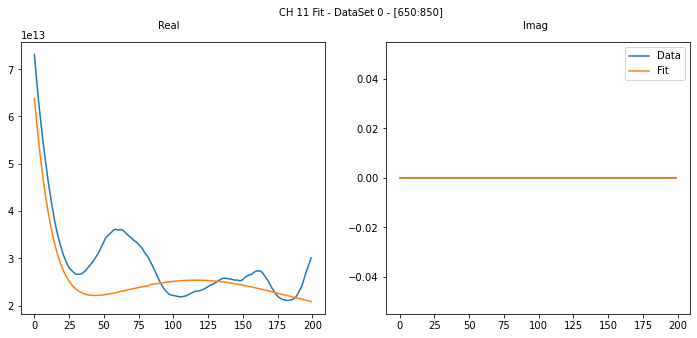

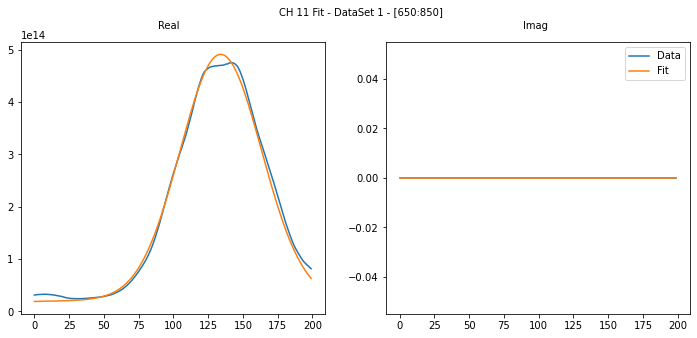

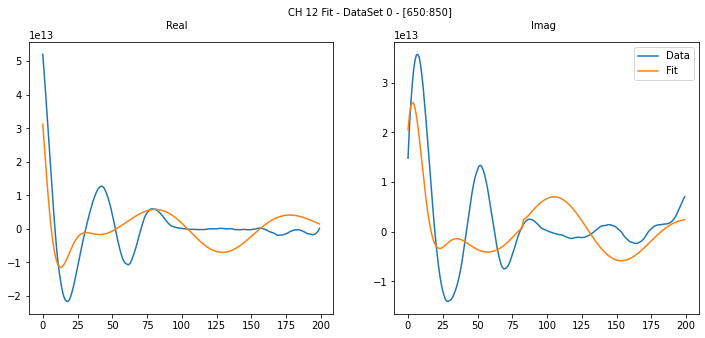

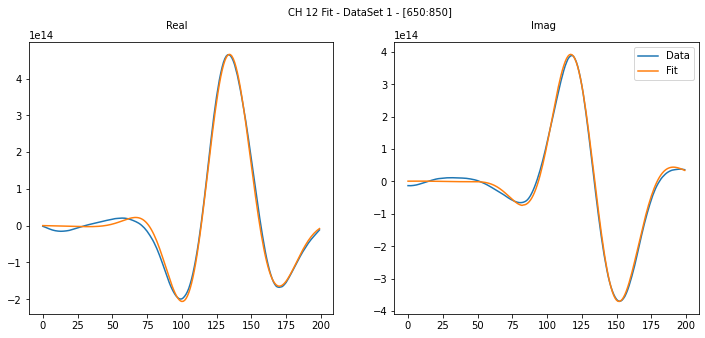

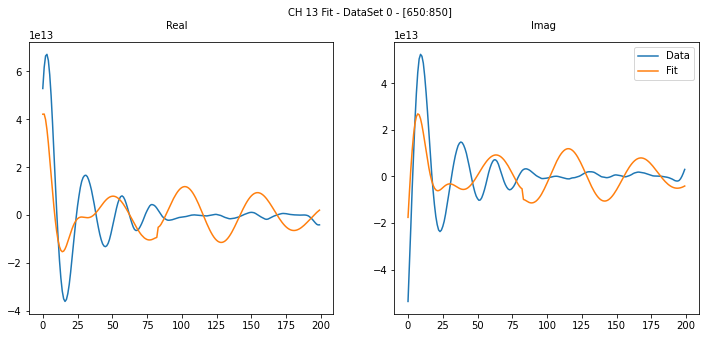

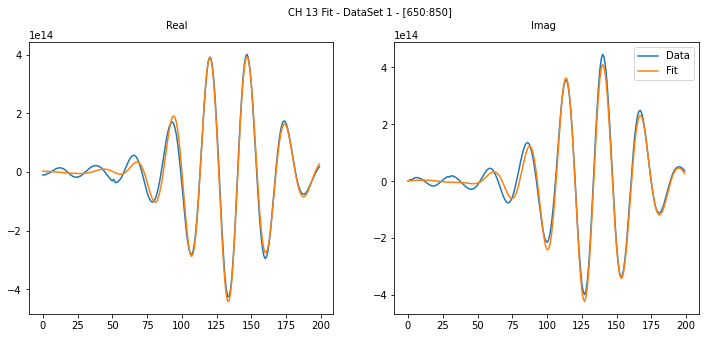

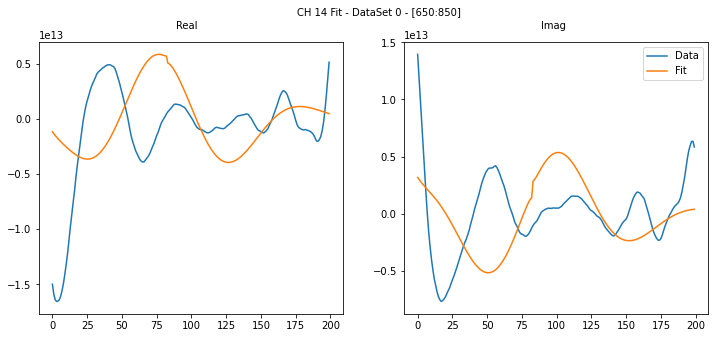

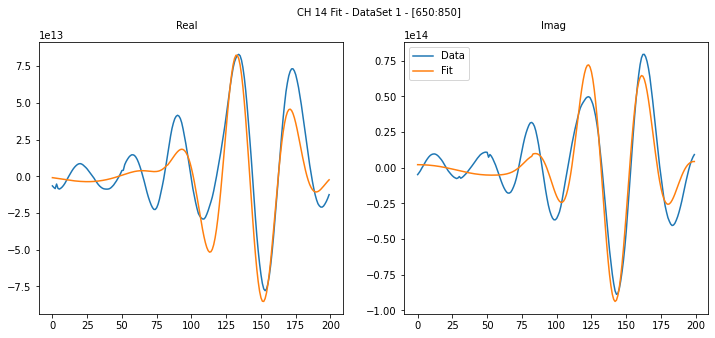

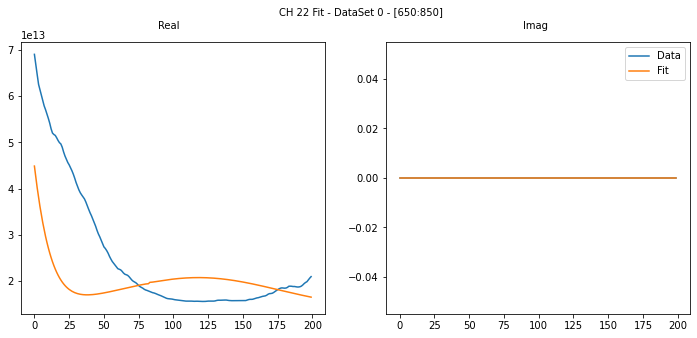

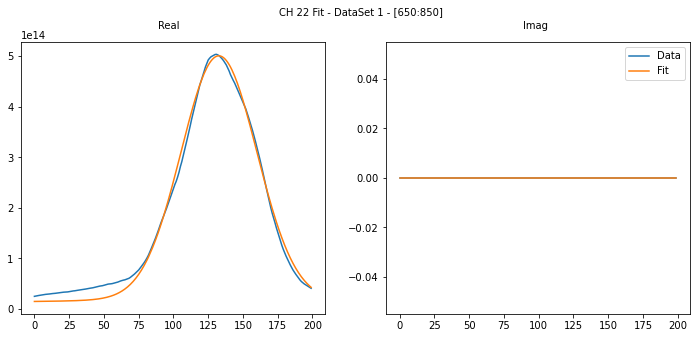

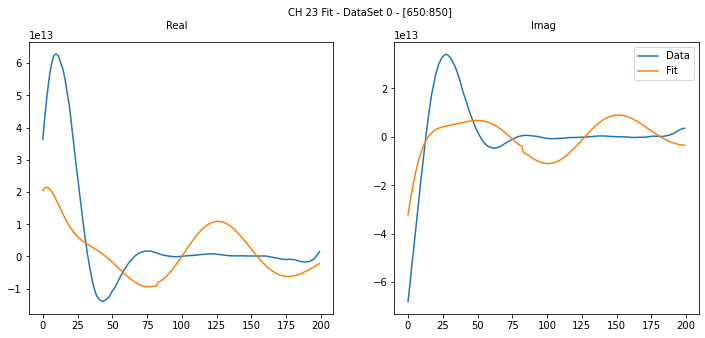

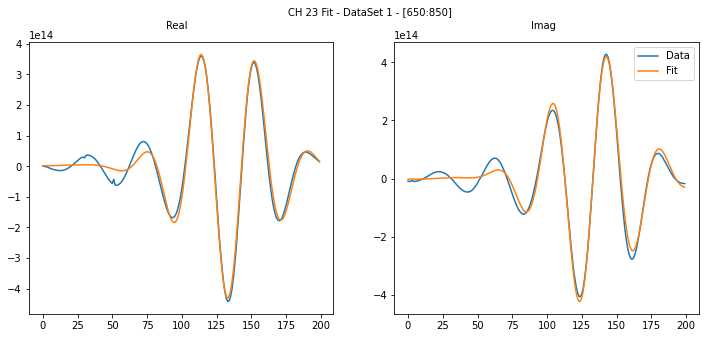

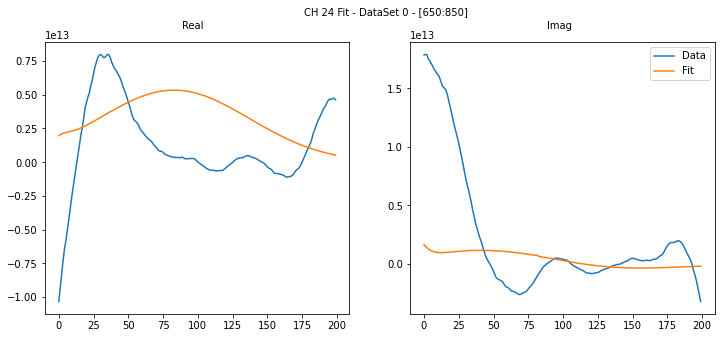

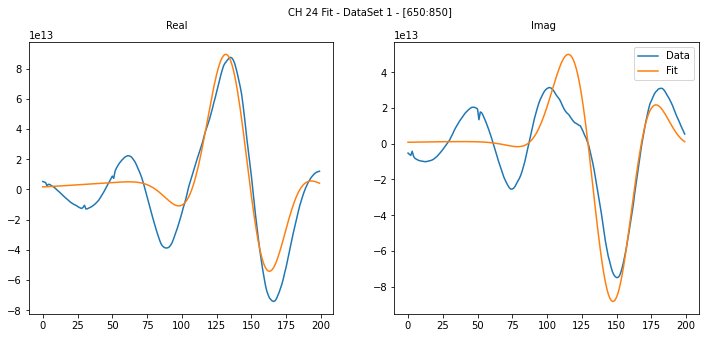

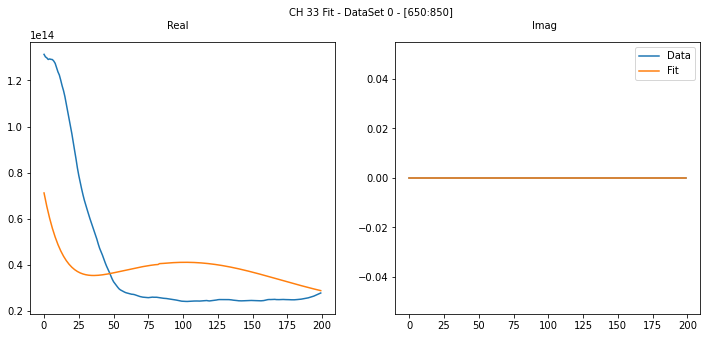

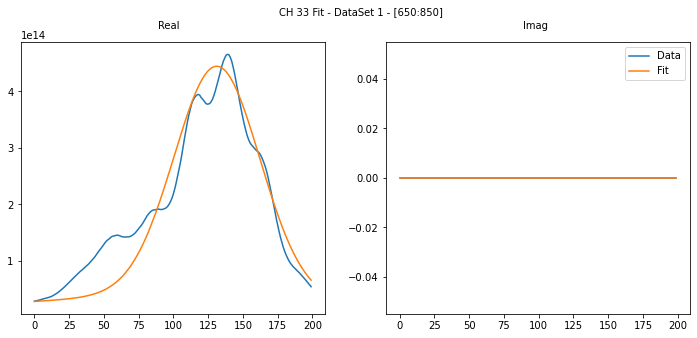

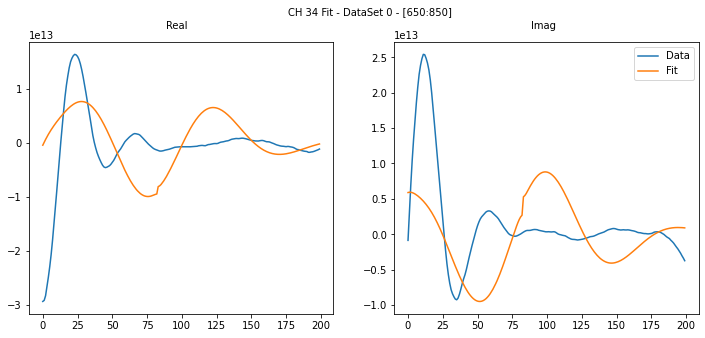

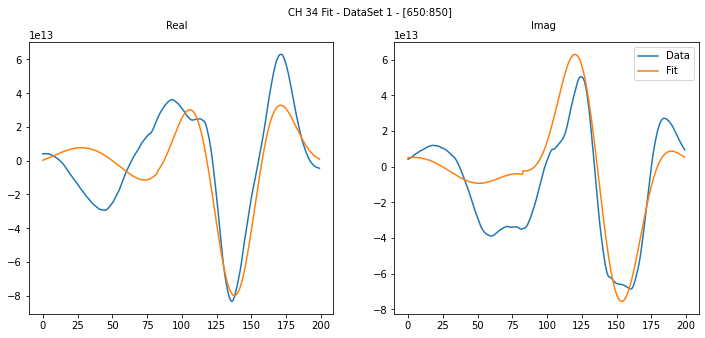

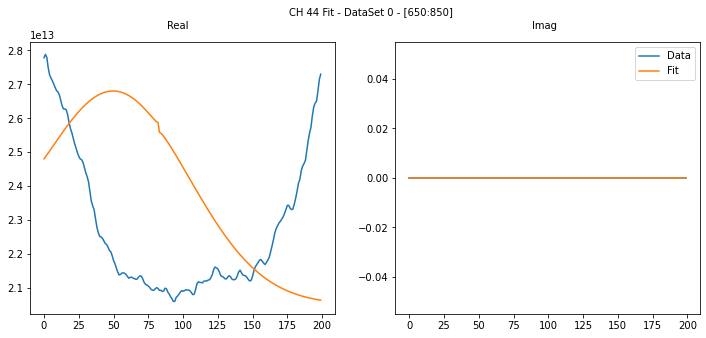

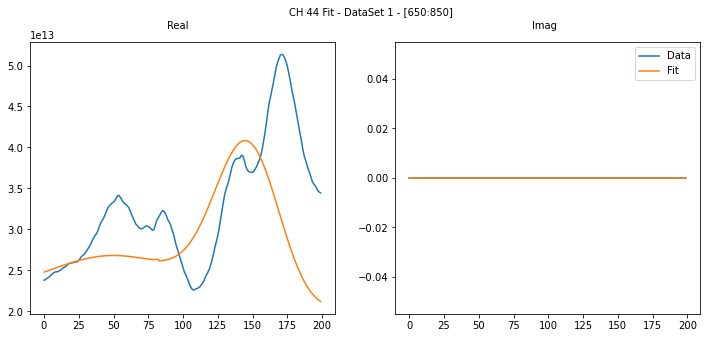

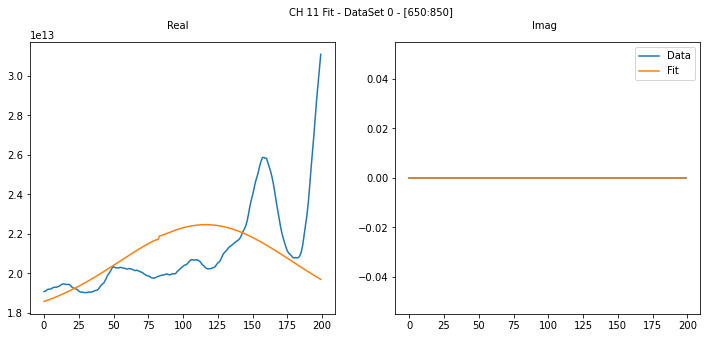

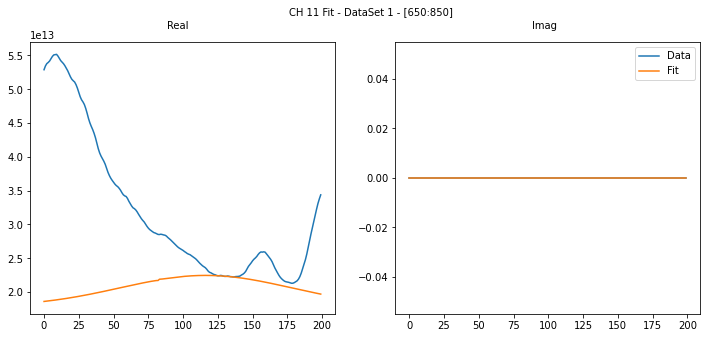

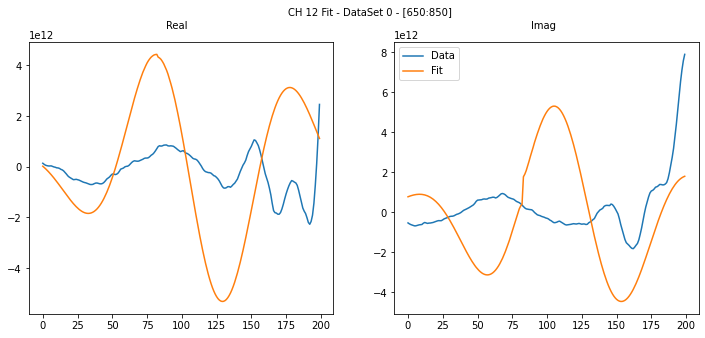

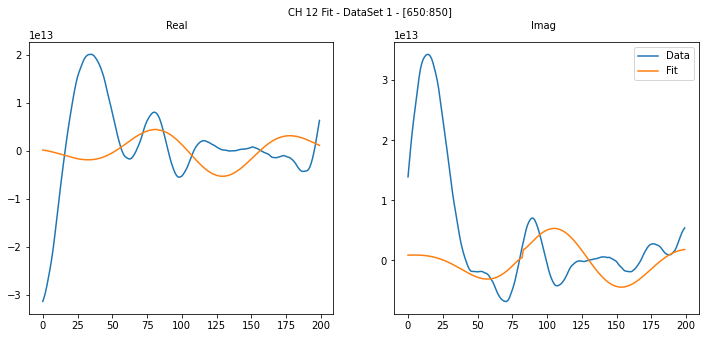

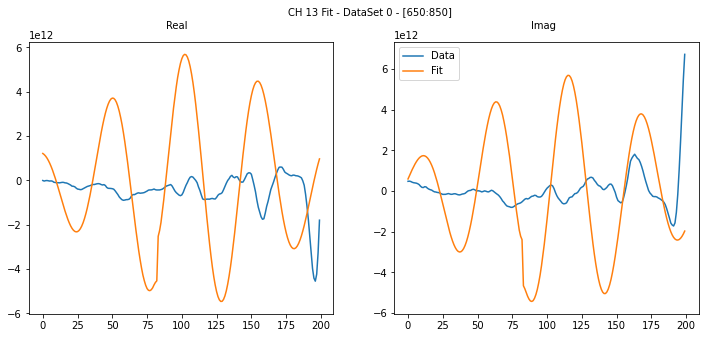

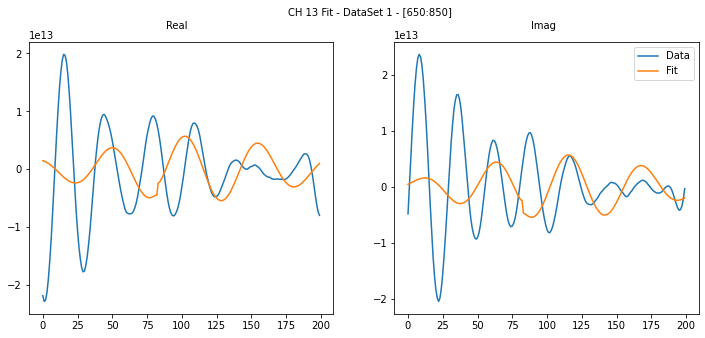

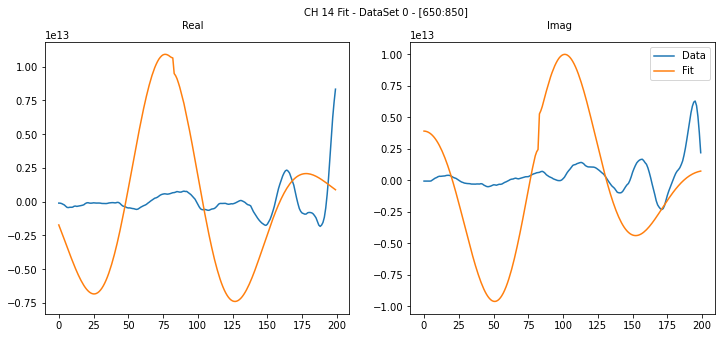

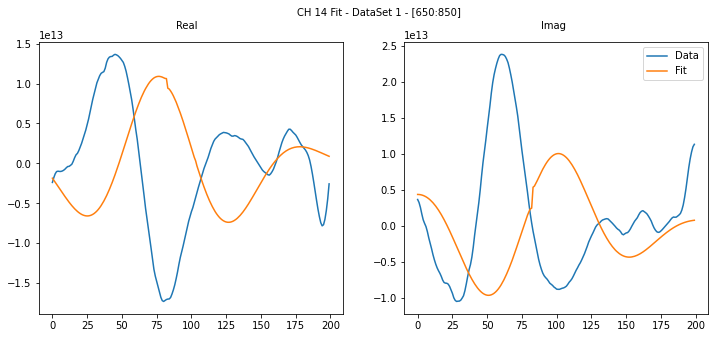

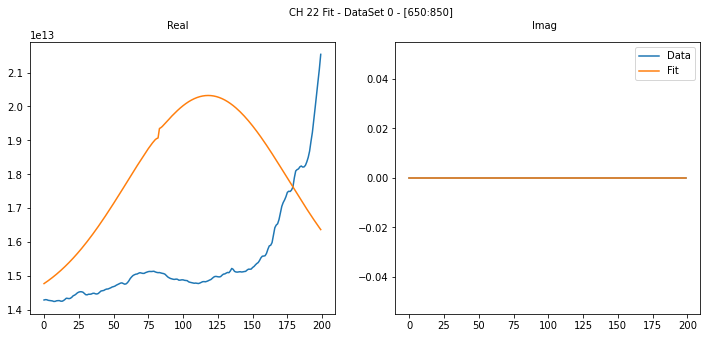

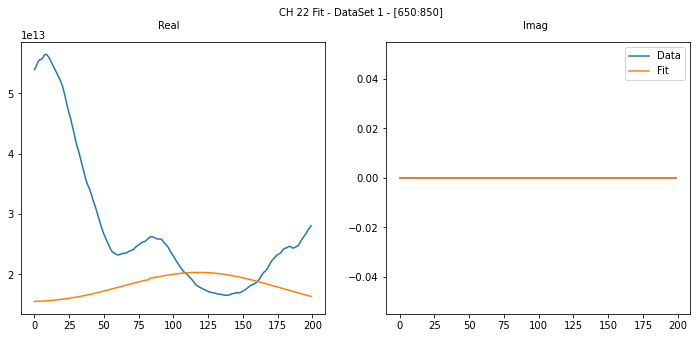

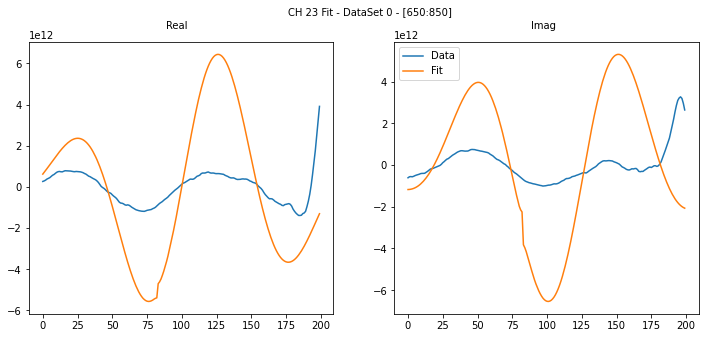

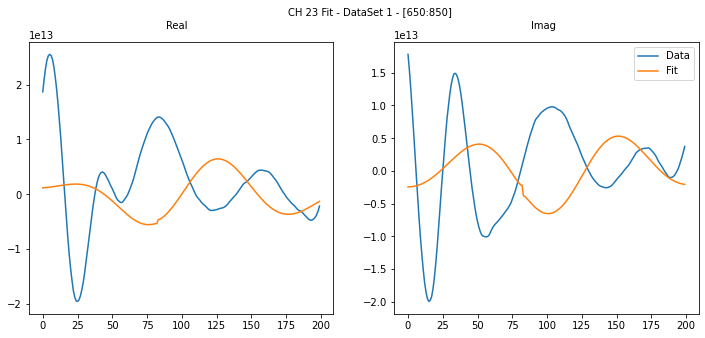

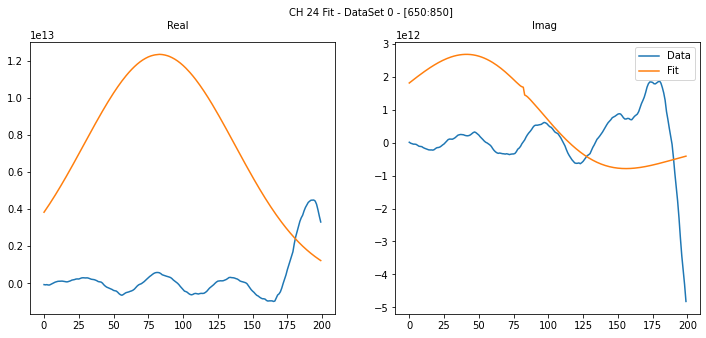

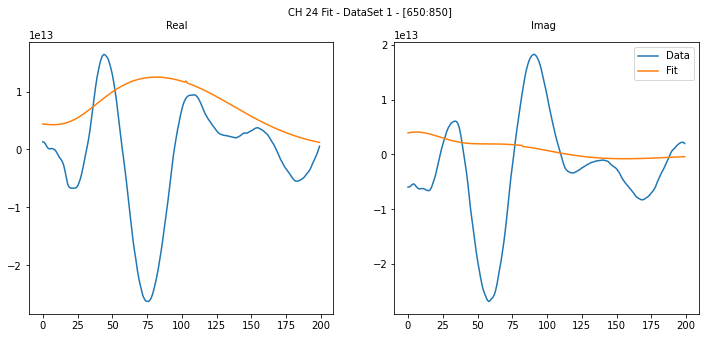

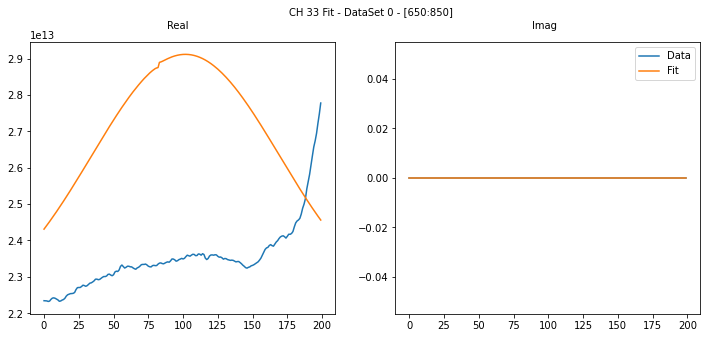

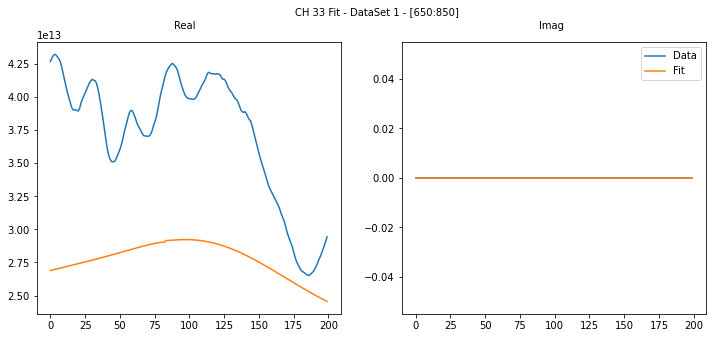

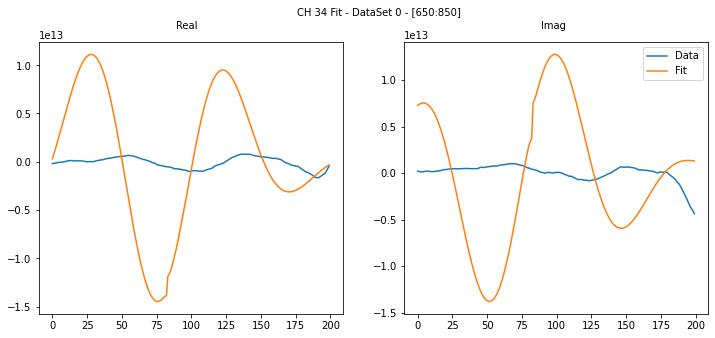

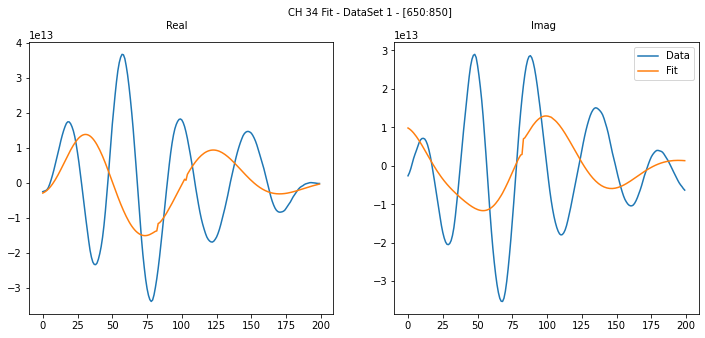

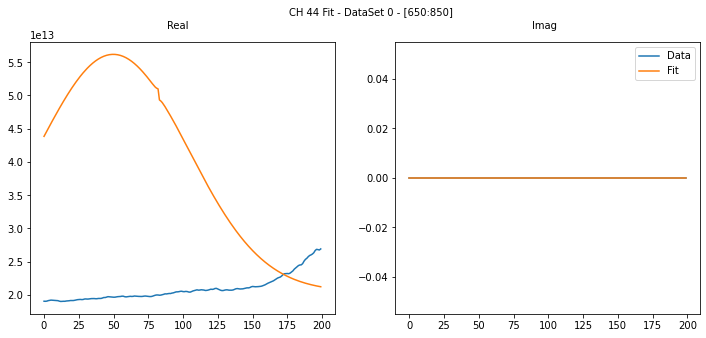

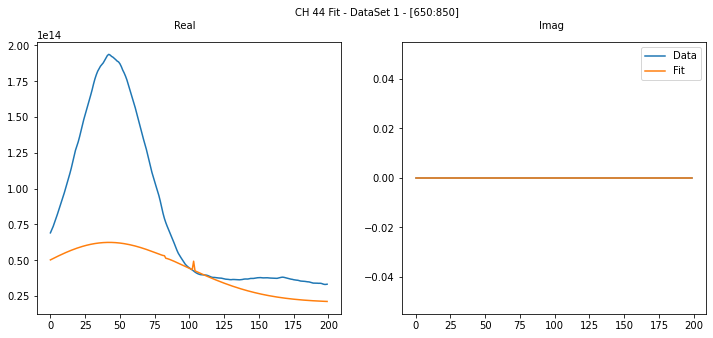

In [18]:
cut = [650,850]
channels = [11,12,13,14,22,23,24,33,34,44]
mode = 'all'

for T in Theories:
    T.showFit(channels = channels, cut=cut,mode=mode)

In [95]:
for T in Theories:
    print(T.readParameters())
    print()

{'A1_BEIDOU-3_M15_(C34)': 19871503.964947823, 'A2_BEIDOU-3_M15_(C34)': -22915411.603287116, 'A3_BEIDOU-3_M15_(C34)': 26741845.865535285, 'A4_BEIDOU-3_M15_(C34)': -26964602.571404982, 'A5_BEIDOU-3_M15_(C34)': -1088162.62538471, 'A6_BEIDOU-3_M15_(C34)': -905303.554509838, 'A7_BEIDOU-3_M15_(C34)': 7547127.383132365, 'A8_BEIDOU-3_M15_(C34)': 13273909.93678904, 'BEIDOU-3_M15_(C34)_track_offset_x': 0.0, 'BEIDOU-3_M15_(C34)_track_offset_y': 0.0, 'BEIDOU-3_M15_(C34)_time_offset': 0, 'A1_GSAT0212_(PRN_E03)': 22189878.69492923, 'A2_GSAT0212_(PRN_E03)': 22042620.921747178, 'A3_GSAT0212_(PRN_E03)': 22889143.779523935, 'A4_GSAT0212_(PRN_E03)': 26152245.419313893, 'A5_GSAT0212_(PRN_E03)': 5455725.40320663, 'A6_GSAT0212_(PRN_E03)': 5326615.612285059, 'A7_GSAT0212_(PRN_E03)': 8516107.560005201, 'A8_GSAT0212_(PRN_E03)': 15292303.272671316, 'GSAT0212_(PRN_E03)_track_offset_x': 0.0, 'GSAT0212_(PRN_E03)_track_offset_y': 0.0, 'GSAT0212_(PRN_E03)_time_offset': 0, 'A1_GSAT0103_(PRN_E19)': -249309.12249046855

In [21]:
ALT = 1.5695515
LAT = 0.7122296
dec = 0.7109409436737796
print(np.cos(ALT))
print((np.sin(dec) - np.sin(ALT)*np.sin(LAT))/(np.cos(ALT)*np.cos(LAT)))
print((np.cos(LAT)*np.sin(dec) - np.cos(dec)*np.sin(LAT))/np.cos(ALT))

0.0012448264734006857
-1.035247831211882
-1.0352093220153251
